## Access Satellite GHRSST L3S 1Day Daynighttime Multi Sensor Southern Ocean data in Zarr
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l3s_1day_daynighttime_multi_sensor_southernocean dataset available as a [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/).

In [1]:
dataset_name = "satellite_ghrsst_l3s_1day_daynighttime_multi_sensor_southernocean"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [3]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 34ms


In [4]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [5]:
from DataQuery import plot_gridded_variable, create_timeseries, plot_time_coverage

In [6]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), chunks=None, consolidated=True)
ds

<xarray.Dataset> Size: 7TB
Dimensions:                          (time: 2197, lat: 2500, lon: 10000)
Coordinates:
  * lat                              (lat) float32 10kB -27.51 -27.53 ... -77.49
  * lon                              (lon) float32 40kB 2.51 2.53 ... 202.5
  * time                             (time) datetime64[ns] 18kB 2018-11-16T11...
Data variables: (12/17)
    dt_analysis                      (time, lat, lon) float64 439GB ...
    filename                         (time) <U68 598kB ...
    l2p_flags                        (time, lat, lon) float64 439GB ...
    quality_level                    (time, lat, lon) float64 439GB ...
    satellite_zenith_angle           (time, lat, lon) float64 439GB ...
    sea_ice_fraction                 (time, lat, lon) float64 439GB ...
    ...                               ...
    sst_count                        (time, lat, lon) float64 439GB ...
    sst_dtime                        (time, lat, lon) float64 439GB ...
    sst_mean                         (time, lat, lon) float64 439GB ...
    sst_standard_deviation           (time, lat, lon) float64 439GB ...
    wind_speed                       (time, lat, lon) float64 439GB ...
    wind_speed_dtime_from_sst        (time, lat, lon) float64 439GB ...
Attributes: (12/47)
    Conventions:                CF-1.6
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Metadata_Link:              TBA
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              grid
    comment:                    Multi-sensor L3S retrievals produced by the A...
    ...                         ...
    summary:                    Skin sea surface temperature retrievals from ...
    time_coverage_end:          20241112T230957Z
    time_coverage_start:        20241111T162900Z
    title:                      IMOS L3S Day and Night gridded multiple-senso...
    uuid:                       98464caf-34bf-423f-93f0-c6981d223af6
    westernmost_longitude:      2.509999990463257

## Plot time coverage

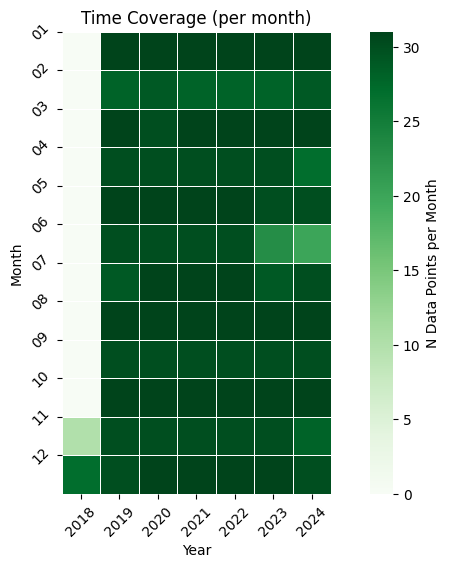

In [7]:
plot_time_coverage(ds)

## Timeseries at a point

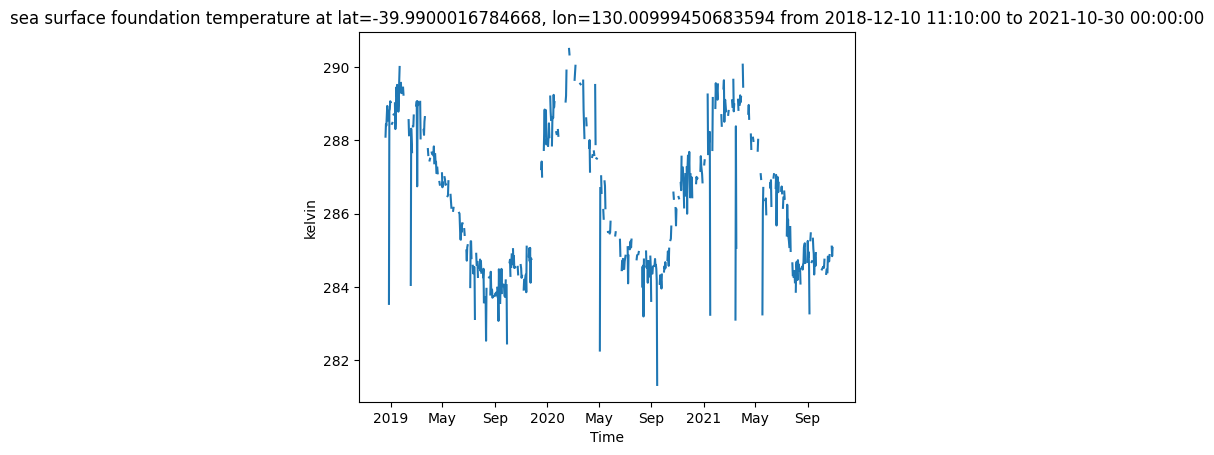

CPU times: user 11.9 s, sys: 3.95 s, total: 15.8 s
Wall time: 1min 7s


In [8]:
%%time
time_series_df = create_timeseries(ds, 'sea_surface_temperature', lat=-40, lon=130, start_time='2018-12-10 11:10:00', end_time='2021-10-30')

## Plot a gridded variable

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('2020-01-26T11:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-01-26T11:10:00
Attributes:
    axis:           T
    comment:        A typical reference time for data
    long_name:      reference time of sst file
    standard_name:  time
Variable Long Name: sea ice fraction


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:880: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


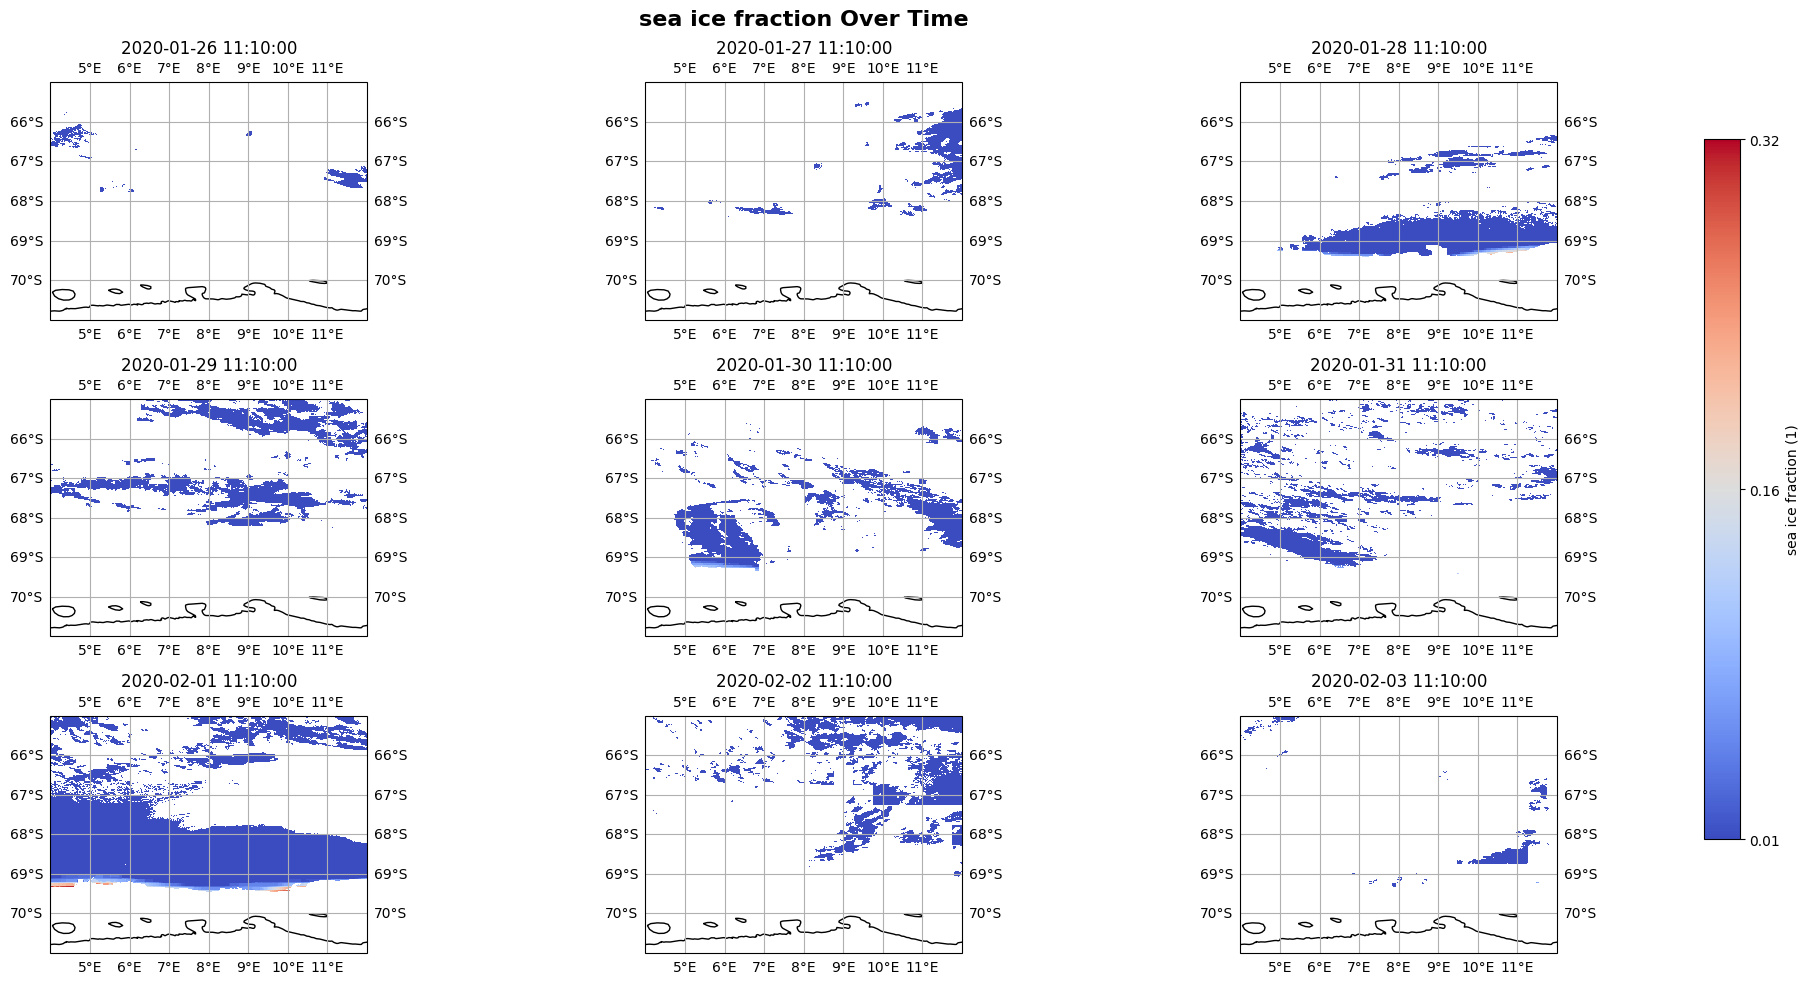

CPU times: user 4.22 s, sys: 3.13 s, total: 7.35 s
Wall time: 4.99 s


In [9]:
%%time
plot_gridded_variable(ds, start_date='2020-01-26', lon_slice=(4, 12), lat_slice=(-71, -65), var_name='sea_ice_fraction', n_days=9, coastline_resolution="10m")

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('2023-01-02T11:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-01-02T11:10:00
Attributes:
    axis:           T
    comment:        A typical reference time for data
    long_name:      reference time of sst file
    standard_name:  time
Variable Long Name: sea surface foundation temperature


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:880: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


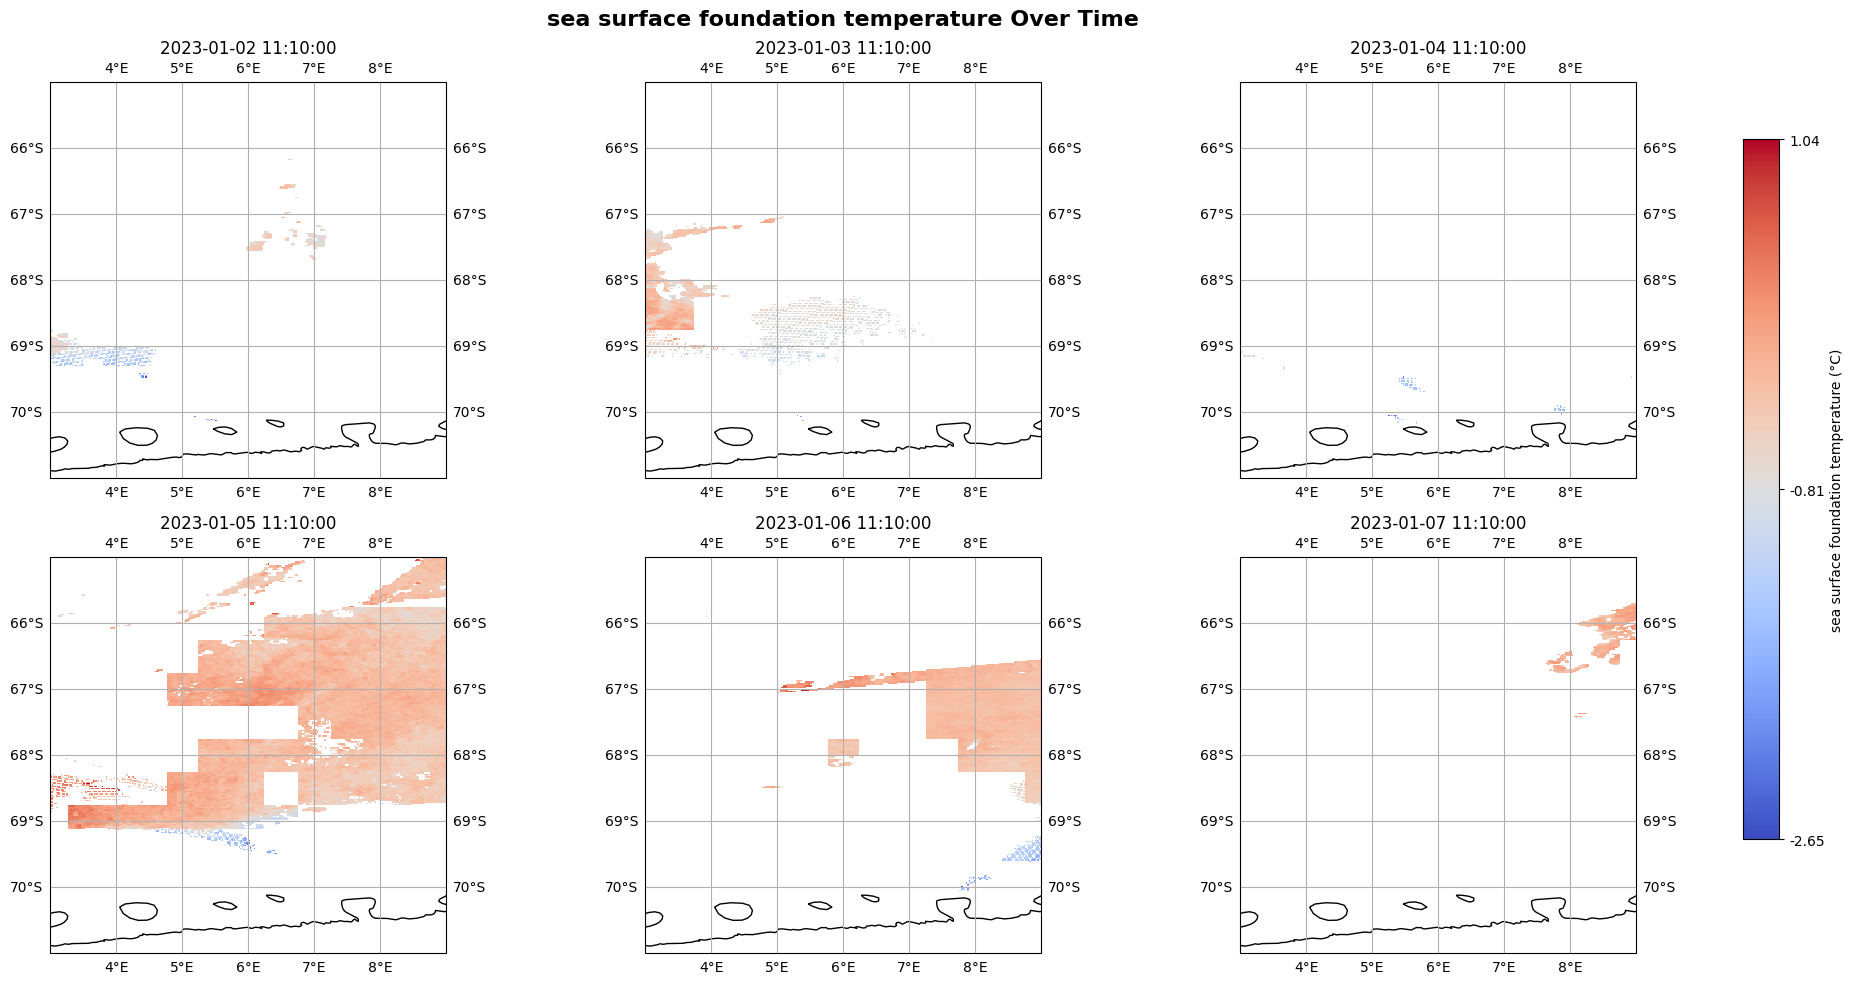

In [10]:
plot_gridded_variable(ds, start_date='2023-01-02', lon_slice=(3, 9), lat_slice=(-71, -65), var_name='sea_surface_temperature', coastline_resolution="10m")

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('2020-11-25T11:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-11-25T11:10:00
Attributes:
    axis:           T
    comment:        A typical reference time for data
    long_name:      reference time of sst file
    standard_name:  time
Variable Long Name: sea surface foundation temperature


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:880: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


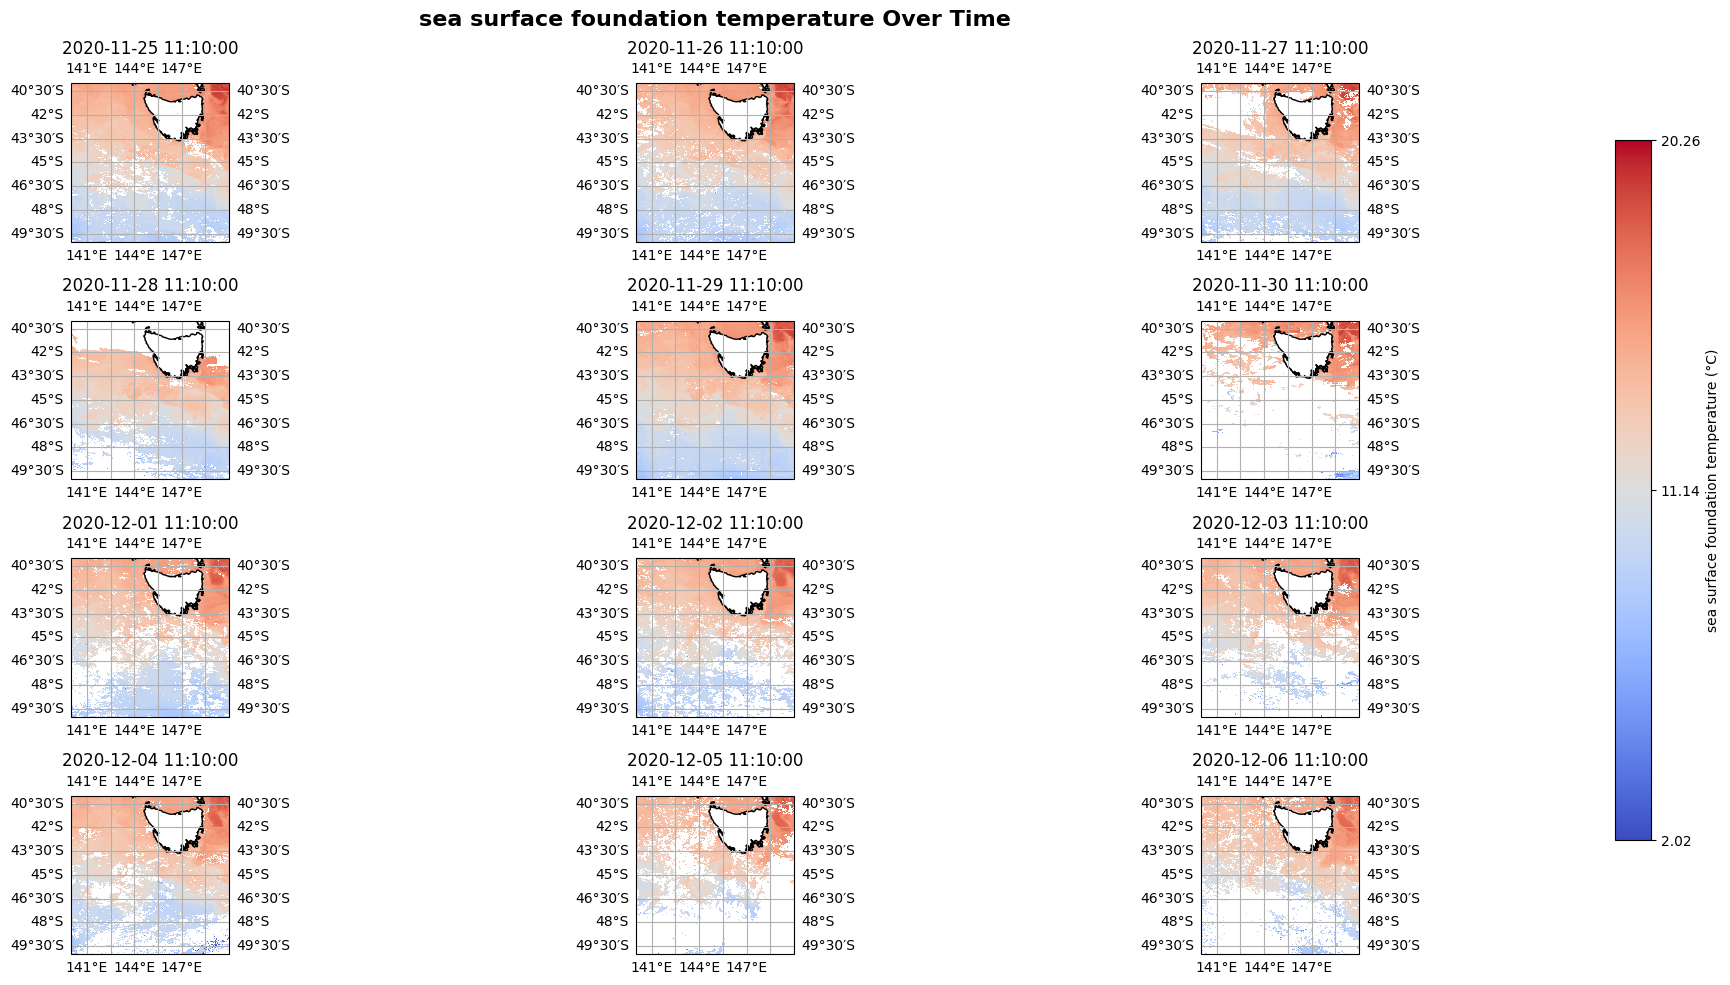

In [11]:
plot_gridded_variable(ds, start_date='2020-11-25', lon_slice=(140, 150), lat_slice=(-50, -40), var_name='sea_surface_temperature', coastline_resolution="10m", n_days=12)

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

def daily_avg_sea_ice_fraction(ds, lon_slice, lat_slice, start_date=None, end_date=None, var_name='sea_ice_fraction'):
    """
    Computes and plots the daily average of sea_ice_fraction over a given region (lon_slice, lat_slice)
    for a specified time range, bounded by dataset limits if necessary.

    Parameters:
    - ds: xarray.Dataset containing the sea ice data.
    - lon_slice: tuple, longitude slice (start_lon, end_lon). (min val, max val)
    - lat_slice: tuple, latitude slice (start_lat, end_lat). (min val, max val)
    - start_date: str, start date in 'YYYY-MM-DD' format (optional).
    - end_date: str, end date in 'YYYY-MM-DD' format (optional).
    - var_name: str, variable name to calculate the average for (default is 'sea_ice_fraction').

    Returns:
    - xarray.Dataset containing the daily average of sea_ice_fraction for the specified region and time period.
    """

    ds = ds.sortby('time')


    # Decide on the slice order
    if ds.lat[0] < ds.lat[-1]:
        lat_slice = lat_slice
    elif ds.lat[0] > ds.lat[-1]:  
        lat_slice = lat_slice[::-1]

    # Ensure the dataset has a time dimension
    assert 'time' in ds.dims, "Dataset does not have a 'time' dimension"

    # Determine the dataset's time range
    dataset_start = pd.to_datetime(ds.time.min().values)
    dataset_end = pd.to_datetime(ds.time.max().values)

    # Parse the start and end dates, default to dataset limits if necessary
    start_date = pd.to_datetime(start_date) if start_date else dataset_start
    end_date = pd.to_datetime(end_date) if end_date else dataset_end

    # Bound the start and end dates within the dataset's time range
    if start_date < dataset_start:
        start_date = dataset_start
    if end_date > dataset_end:
        end_date = dataset_end

    # Select the time range and area
    selected_data = ds.sel(
        lon=slice(lon_slice[0], lon_slice[1]),
        lat=slice(lat_slice[0], lat_slice[1]),
        time=slice(start_date, end_date)
    )

    # Compute the boolean masks for quality level and flags on the selected data
    quality_mask = (selected_data['quality_level'] >= 4).compute()
    flags_mask = (selected_data['l2p_flags'] != 2).compute()

    # Apply masks to filter the dataset
    filtered_ds = selected_data.where(quality_mask & flags_mask, drop=True)

    # Calculate the daily average over the filtered area
    daily_avg = filtered_ds[var_name].mean(dim=['lon', 'lat']).resample(time='1D').mean()

    # Calculate percentage of non-NaN values
    valid_data_count = filtered_ds[var_name].count(dim=['lon', 'lat']).resample(time='1D').sum()
    total_data_count = selected_data[var_name].count(dim=['lon', 'lat']).resample(time='1D').sum()
    percentage_valid = (valid_data_count / total_data_count) * 100

    # Plot the time series of daily average sea_ice_fraction
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot daily average sea ice fraction
    daily_avg.plot(ax=ax1, color='blue', marker='o', linestyle='-', label='Daily Avg Sea Ice Fraction')
    ax1.set_ylabel(f"{ds[var_name].attrs.get('units', 'unitless')} (%)")
    ax1.set_title(f"Daily Average {ds[var_name].attrs.get('long_name', var_name)} ({start_date.date()} to {end_date.date()})")
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    ax1.grid(True)

    # Create a second y-axis to plot percentage of valid data
    ax2 = ax1.twinx()
    percentage_valid.plot(ax=ax2, color='orange', marker='x', linestyle='-', label='Percentage of Measured Data Points in Grid')
    ax2.set_ylabel("Percentage of Measured Data Points in Grid (%)")
    ax2.set_ylim(0, 100)  # Set limits for the percentage axis

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.show()

    # Return the daily average as an xarray.Dataset
    return daily_avg.to_dataset(name=f'daily_avg_{var_name}')


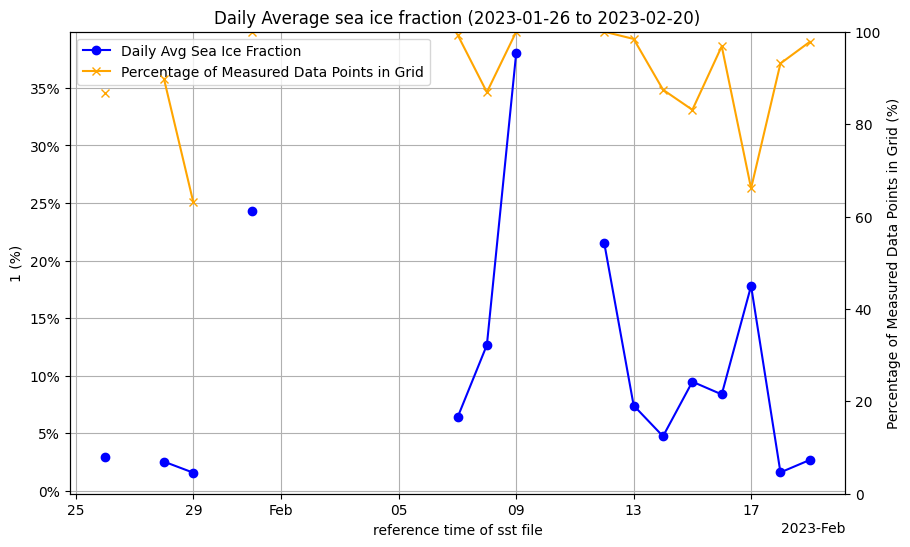

In [13]:
result_ds = daily_avg_sea_ice_fraction(ds, lon_slice=(5, 7), lat_slice=(-71, -69), start_date='2023-01-26',  end_date='2023-02-20', var_name='sea_ice_fraction')